# Quantum Simulation of Hamiltonians using Product Formulas

**Please execute the cell below before proceeding:**

In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from scipy import linalg as sla
import itertools as iter
from scipy.spatial import distance
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, LogarithmicMapper
from qiskit.primitives import Estimator
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, commutator
from qiskit.primitives import Estimator
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.algorithms import TimeEvolutionProblem
from qiskit.algorithms.time_evolvers import TrotterQRTE
from qiskit.circuit import Parameter
from qiskit.synthesis import SuzukiTrotter, LieTrotter, MatrixExponential


## Contents:

1. [Introduction](#introduction)
2. [Theory](#theory)
2. [Electronic Hamiltonian](#electronic-hamiltonian)
3. [Heisenberg Hamiltonian](#heisenberg-model-lattice-based)
4. [Ising Hamiltonian](#ising-model-lattice-based)
5. [Discussion](#discussion)
6. [Citations](#citations)


## Introduction

Quantum simulation is a method for understanding the attributes of physical systems over defined intervals of time. Such a technique can be used to emulate the time evolution of a physical system’s Hamiltonian operator given an initial state of the system. 
    
However, the accuracy of simulation is dependent upon the algorithm employed: the quantum circuit constructed to simulate a system can offer both benefits and deficits regarding query complexity, circuit depth, success rate, and error. [1] These four characteristics will be explored via the use of product formulas, which are algorithms that comprise Lie-Trotter-Suzuki decomposition methods. Although product formulas now compete with more recent algorithms, such as qubitization [12, 13] and quantum walks [14, 15, 16], these formulas are still a favorable place to begin exploring quantum simulation algorithms applied to quantum dynamics due to their relatively simple structure, lack of ancilla qubits, and high success probability [9]. Product formulas also provide a good ideal evolution approximation at `low time intervals (e.g., ${t ≪ 1}$) [3]. 

This tutorial will primarily focus on the circuit depth and error characteristics of first- and even higher-order product formulas at various evolution times. A comparison between a the ideal time evolution and product formulas is included to better illustrate the computational benefits and deficits of both approaches. These comparisons will feature Electronic, Heisenberg, and Ising Hamiltonians. Prior to these topics, an explanation covering the structure and practical implementation of product formulas is necessary.

## Theory of Product Formulas

Product Formulas, within this notebook, will be presented in one of two forms: first order Lie-Trotter formulas [2] and higher-order Suzuki formulas [6]. These two forms realize a product formula for a Hamiltonian with structure:

$$ \large H = \sum_{γ=1}^{Γ} {H_γ}$$

where ${Γ}$ is equal to the total number of summands, or sub-operators, within the Hamiltonian operator, and ${H_γ}$ denotes a ${γ}$-ordered summand within the Hamiltonian. Summands may adopt the form of primitive Pauli operators (i.e., ${\sigma_x, \sigma_y, \sigma_z}$) or a string of such operators, termed a Pauili string (e.g., ${\sigma_x \sigma_y \sigma_x}$). Broadly, valid Hilbert space operators may comprise the Hamiltonian. In general, a pth-order product formula can be expressed as:

$$\large \mathscr{T}_{p}(t) := \prod_{\upsilon=1}^{\Upsilon} \prod_{\gamma = 1}^{\Gamma} e^{t a_{(\upsilon, \gamma)} H_{\pi_{\upsilon (\gamma)}}} = e^{-itH} + \mathcal{O}(\frac{t^{p+1}}{r})$$ 

where ${ⅇ^{-itH}}$ is the unitary operator used in evolving an initial state, and ${O(\frac{t^{p+1}}{r})}$ is the Trotter Error of the product formula [3]. Further information on this general format will follow.

The circuit implementations of these two algorithm formats incurs an associated error term that signals a deviation factor from the idealized time evolution of a system. This error term is defined as the Trotter Error of a product formula [8]. The Trotter Error of a system can be influenced by the gate complexity, number of qubits in the input register, and total time for which the system evolves.

Moreover, the structure of the error term is dependent upon the structure and order of the product formula in which it appears. These error terms will be further explored within the respective definitions of Lie-Trotter/Suzuki formulas and Qiskit demonstrations that follow.

First order Lie-Trotter product formulas possess the simplest decomposition structures [2] and have a Trotter error that scales relative to a truncation of the Taylor expansion of the unitary operator [11]. This culminates to a product formula structure:

$$ \large \mathscr{T}_{1} (\tau) := e^{\tau H_{\Gamma}} ... e^{\tau H_{1}} = e^{-itH} + \mathcal{O}(\frac{t^2}{r})$$

where, ${O(\tau^2)}$, is the associated Trotter Error of the system. In this context, ${\tau}$ is representative of the ratio ${t/r}$, where ${r}$ is the Trotter Number of the product formula. The Trotter Number coefficient will be discussed shortly. The Big-O bound, ${\mathcal{O}}$, refers to the variable ${\tau \rightarrow 0}$, for large ${t}$, in place of ${\infty}$. This particular formula can be constructed from the general pth-order product formula by noting that the order, ${p}$, is equal to 1. Despite this simple structure, the Trotter Error neglects significant terms that are dropped when truncating the Taylor expansion, thus rendering Lie-Trotter structures convenient but inaccurate in analyzing Trotter Error [1]. 

Higher-order Suzuki product formulas use symmetric decomposition structures, termed integrators, to simulate the time evolution of a Hamiltonian [10]. The second-order Suzuki formula, along with its generalized higher-order variant and associated recursive formula, is:

$$ \large \mathscr{T}_{2} (\tau) := e^{\frac{\tau}{2} H_1} ... e^{\frac{\tau}{2} H_{\Gamma}} e^{\frac{\tau}{2} H_{\Gamma}} ... e^{\frac{\tau}{2} H_{1}} , \newline \mathscr{T}_{2k} (\tau) := \mathscr{T}_{2k - 2} (u_k \tau)^2 \mathscr{T}_{2k - 2} ((1 - 4 u_k) \tau) \mathscr{T}_{2k - 2} (u_k \tau)^2$$

where ${u_k = 1 / (4-4^{1/(2k-1)})}$ and ${k}$ denotes the order of the product formula. The upper equation is the symmetric integrator second order product formula, while the lower equation is the recursive equation for calculating an arbitrary even-ordered product formula. Although higher-order Suzuki formulas have been proven to possess a tighter Trotter Error bound than first order Lie-Trotter formulas [17], this bound does not take advantage of the commutativity of the Hamiltonian summands.

This tutorial will employ the following product formula generalization and Trotter Error approximation scheme:

$$\large \mathscr{T}_{p}(\tau) := \prod_{\upsilon=1}^{\Upsilon} \prod_{\gamma = 1}^{\Gamma} e^{\tau a_{(\upsilon, \gamma)} H_{\pi_{\upsilon (\gamma)}}}, \\[0.2in] with \ Trotter \ Error: \mathcal{O} (\frac{\tilde{\alpha}_{comm} t^{p+1}}{r})$$ 

where $$ \tilde{α}_{comm} ≔ \sum_{γ_{1},γ_2,…,γ_{p+1}} \lVert [H_{γ_{p+1}},…[H_{γ_2},H_{γ_1}]] \rVert $$  is the commutator pre-factor (i.e., summation of spectral norms of the nested summand commutator), ${ϒ}$ is the number of stages in the formula, ${\upsilon}$ represents the ${\upsilon}$-th stage, ${a_{(\upsilon,γ)}}$ is an arbitrary non-zero, real coefficient, and ${π_{ν(γ)}}$ is the permutation order of the product formula [3]. The latter two parameters do not have a significant bearing on the analysis of Trotter Error. A proof for the commutator pre-factor can be found here: [4] Moreover, this product formula is accompanied by a term known as the Trotter Number. Its expression is:

$$ \large r = \mathcal{O} (\frac{ \tilde{\alpha}_{comm}^{\frac{1}{p}} t^{1 + \frac{1}{p}}}{\epsilon^{\frac{1}{p}}})$$

where ${ε}$ is the target accuracy that we wish to simulate within a system [4]. The Trotter Number is a useful utility in that it allows us to repeat the product formula and manipulate the time step of the constructed trotterization. The variable ${ε}$ will be set to a constant equal to ${1.6*10^{-3}}$ a.u. throughout the tutorial. Gate complexity of generated product formulas grow with increasing order and Trotter Number [24]. In this context, gate complexity refers to the number of trotterized unitary gates used to express the specified product formula [25]. The associated constant accuracy gate complexity, such that the associated Trotter Error is at most ${\mathcal{O}(\epsilon)}$, of product formulas with commutator scaling is:

$$ \large \mathcal{O} (\Gamma \frac{ \tilde{\alpha}_{comm}^{\frac{1}{p}} t^{1 + \frac{1}{p}}}{\epsilon^{\frac{1}{p}}})$$

which resolves to

$$ \large \mathcal{O} (\Gamma r) $$

Of note, the Trotter Error of this generalized product formula is due to the assumed anti-Hermitian nature of the Hamiltonian; anti-hermiticity appears within quantum chemistry applications, and this permits the Trotter Error to be simplified to the above form [8]. These items in tandem will allow us to produce a trotterization of a unitary operator, approximate the ideal evolution of a system, and analyze the entailing Trotter Error of the product formula.



## Electronic Hamiltonian

### Dihydrogen Molecule (Molecular Orbital Basis):

The Electronic Hamiltonian represents the internal energies of a molecule following the removal of kinetic energy terms from the Hamiltonian due to Born-Oppenheimer approximation [19]. This Hamiltonian has the nuclear coordinate form:

$$ \large \mathcal{H}_{el} = - \sum_{i}{\frac{\nabla^{2}_{r_i}}{m_e}} - \sum_{I}{\sum_{i}{\frac{Z_I e^2}{\mid R_I - r_i \mid}}} \ + \ \sum_{i}{\sum_{j>i}{\frac{e^2}{\mid r_i - r_j \mid}}} $$

where ${r_i}$ and ${r_j}$ are the coordinates of the ${i}$-th and ${j}$-th electron, respectively, ${m_e}$ is the mass of the electron, ${Z_I}$ is the atomic number of the nucleus ${I}$, ${R_I}$ are the coordinates of the nucleus ${I}$, and ${e}$ is the electron charge [17]. This form will not be relevant to practical applications of product formulas. The second quantized form (Molecular Orbital basis) of the Electronic Hamiltonian is:

$$ \large \hat{H}_{elec} = \sum_{pq}{h_{pq} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger}} \ + \ \frac{1}{2} \sum_{pqrs}{h_{pqrs} \hat{a}_{p}^{\dagger} \hat{a}_{q}^{\dagger} \hat{a}_{r} \hat{a}_{s}} $$

where ${\hat{a}_{k}^{†}}$ and ${\hat{a}_{k}}$ , with ${k = pq,\ pqrs,\ p,\ q,\ r,\ s}$,  are the creation and annihilation operators of the fermions, and ${h_{pq}}$ and ${h_{pqrs}}$
are the 1-body and 2-body integrals, respectively. Further information regarding second quantized Electronic Hamiltonians can be found here: [18]. Using the Jordan-Wigner Transformation, we will bring this fermionic Electronic Hamiltonian into the qubit space to manipulate it.

We will begin learning how to implement both first- and higher-order product formulas using Electronic Hamiltonians via interactive examples. Be sure to read the comments in the code for more notes.


But first, run the following cells to set up the necessary methods used in the Lie-Suzuki-Trotter formulas within this notebook:

In [5]:
# Generate the evolved state vectors and cache their associated coefficients:

def state_generation(hamiltonian, time_range, initial_state):

    state_coefficients = np.empty(shape=(2**(hamiltonian.num_qubits), len(time_range)), dtype=tuple)

    exact_energies = list()

    exact_initial = initial_state.to_instruction()

    exact_initial = Statevector.from_instruction(exact_initial)

    m_exp = MatrixExponential()

    exact_unitary_Exp = PauliEvolutionGate(hamiltonian, time=Parameter('t'), synthesis= m_exp)

    template_Exp = QuantumCircuit(initial_state.width())

    template_Exp = template_Exp.compose(initial_state, range(initial_state.width()))

    template_Exp = template_Exp.compose(exact_unitary_Exp, range(initial_state.width()))

    for k in range(len(time_range)):

        exact_unitary_Exp = PauliEvolutionGate(hamiltonian, time=time_range[k], synthesis= m_exp)

        evolved_state_Exp = exact_initial.evolve(exact_unitary_Exp)

        exact_energies.append(evolved_state_Exp.expectation_value(hamiltonian))

        for j in range(len(evolved_state_Exp.data)):

            coefficients_re = np.real(evolved_state_Exp.data[j])
            coefficients_im = np.imag(evolved_state_Exp.data[j])

            coefficients_pair = (coefficients_re, coefficients_im)
            
            state_coefficients[j][k] = coefficients_pair

    tri = (state_coefficients, exact_energies, template_Exp)

    return(tri)

In [6]:
# Define a function to identify states that have some excitation/probability of being measured:

def identify_states(state_list, hamiltonian, time_range):

   #print("Arrived at identify_states function!")

    meaningful_states = list()

    bool_states = [False] * 2**(hamiltonian.num_qubits)

    for i in range(len(time_range)):

        for j in range(2**(hamiltonian.num_qubits)):

            pair = state_list[j][i]

            if (pair[0] != 0 and pair[1] != 0j):
                bool_states[j] = True
                
    for k in range(len(bool_states)):
        if (bool_states[k] == True):
            meaningful_states.append(k)

    return(meaningful_states)

In [7]:
# Define a first order Product Formula generation function:

def First_Order(hamiltonian, initial_state, trot_num, time_range): 

    # Partition each qubit_h2_Ham list object into separate list of exponentiated summands:

    exp_summand = list()
    evo_time = Parameter('t')
    estimator = Estimator()
    energies = list()
    
    state_coefficients = np.empty(shape=(2**(hamiltonian.num_qubits), len(time_range)), dtype=tuple)
    
    for i in range(0, len(hamiltonian)):
        exp_summand.append(PauliEvolutionGate(hamiltonian[i], time=evo_time))

    # Append PauliEvolutionGates to template circuit, emulating a first order trotterization scheme:

    PF_circuit = QuantumCircuit(initial_state.width()) # Create the templated product formula QuantumCircuit object.

    for i in range(len(exp_summand)):
        PF_circuit.append(exp_summand[i], range(initial_state.width()))

    composed_circ = initial_state # Update the Circuit.

    # Append the initial state and subsequently aggregated circuit to however many repetitions of the PF_circuit are desired:

    for i in range(trot_num):
        composed_circ = composed_circ.compose(PF_circuit, range(initial_state.width()))

    # Calculate the expectation value along evo_time_range array:
    
    for k in range(len(time_range)):
        result = estimator.run(composed_circ, hamiltonian, parameter_values=(time_range[k]/trot_num)).result() 
        energies.append(np.real(result.values)) # Cache the result.

    # Convert the initial HartreeFock state to an instruction

    initial_instruction = initial_state.to_instruction() 
    
    initial_vector = Statevector.from_instruction(initial_instruction) 

    Lie = LieTrotter(trot_num, False, "chain")

    for k in range(len(time_range)):

        exact_unitary_Exp = PauliEvolutionGate(hamiltonian, time=time_range[k], synthesis= Lie)

        template_Exp = QuantumCircuit(initial_state.width())

        template_Exp.compose(exact_unitary_Exp, range(initial_state.width()))

        evolved_state_Exp = initial_vector.evolve(exact_unitary_Exp)

        for j in range(len(evolved_state_Exp.data)):

            coefficients_re = np.real(evolved_state_Exp.data[j])
            coefficients_im = np.imag(evolved_state_Exp.data[j])

            coefficients_pair = (coefficients_re, coefficients_im)
            
            state_coefficients[j][k] = coefficients_pair

    Lie_tuple = (composed_circ, energies, state_coefficients) # Construct a tuple of the composed circuit, associated evolution energies, and evolved state coefficients.

    return (Lie_tuple) # Return the composed first order Product Formula circuit.
    

In [8]:
# Define a 2k-order Product Formula generation function (in addition to obtaining the expectation value):

def  Suzuki(hamiltonian, initial_state, order, trot_num, time_range):

    Suzuki_energies = list()
    estimator = Estimator()

    suzuki_coefficients = np.empty(shape=(2**(hamiltonian.num_qubits), len(time_range)), dtype=tuple)

    # Produce example circuit via Suzuki Trotterization method: 
   
    Suzuki_circ = initial_state.compose(SuzukiTrotter(order, trot_num, insert_barriers=True).synthesize(PauliEvolutionGate(hamiltonian, time=Parameter('t'))))

    # Calculate actual expectation values for circuit/real time evolution over described time interval:

    for k in range(len(time_range)):

        evo_prob = TimeEvolutionProblem(hamiltonian, time_range[k], initial_state) # Generate the initial Time Evolution problem.

        Suzuki = SuzukiTrotter(order, trot_num, True, "chain", None) # Invoke the Suzuki-Trotter formula.

        trotter_qrte = TrotterQRTE(product_formula=Suzuki, estimator=estimator, num_timesteps=trot_num) # Invoke the Trotter Real Time Evolution Algorithm object.

        evolved_state = trotter_qrte.evolve(evo_prob).evolved_state

        result = estimator.run(evolved_state, hamiltonian, None).result()

        Suzuki_energies.append(np.real(result.values))

        evolved_instruction = evolved_state.to_instruction()

        evolved_vector = Statevector.from_instruction(evolved_instruction)

        for j in range(len(evolved_vector.data)):

            coefficients_re = np.real(evolved_vector.data[j])
            coefficients_im = np.imag(evolved_vector.data[j])

            coefficients_pair = (coefficients_re, coefficients_im)
            
            suzuki_coefficients[j][k] = coefficients_pair

    Suzuki_tuple = (Suzuki_circ, Suzuki_energies, suzuki_coefficients)

    return (Suzuki_tuple) 

In [9]:
# Define general Product Formula creation function:

def product_formula(hamiltonian, initial_state, order, trot_num, time_range):

    # hamiltonian = PauliOp or SparsePauliOp Hamiltonian to be Trotterized.
    # initial_state = Initial QuantumCircuit configuration from which the system will be evolved. 
    # order = Order of the desired Product Formula.
    # trot_num = Desired Trotter Number for the Product Formula.
    # time = Time to which the Product Formula will evolve.
    # time_step = Increments at which the system will evolve. 

    if (order < 1):
        return ("Invalid Order Chosen. Choose an integer from [1, inf].") 
    elif (order == 1):
        return First_Order(hamiltonian, initial_state, trot_num, time_range)
    elif (order >= 2):
        return Suzuki(hamiltonian, initial_state, order, trot_num, time_range)
    else:
        return ("Invalid Order Chosen. Use integers!")

In [10]:
# Define an alpha_comm calculation method: 

def a_comm(hamiltonian, order):

    perm_list = list()
    alpha_comm = 0

    perm_list = list(iter.combinations_with_replacement(hamiltonian, order + 1))

    for j in range(len(perm_list)):

        j_list = list(perm_list[j])

        for i in range(len(perm_list[j]) - 1, 0, -1):

            comm = commutator(j_list[i - 1], j_list[i])
            j_list[i - 1] = comm

        op = j_list[0]
        op_adjoint = op.adjoint()

        self_matrix = op_adjoint.compose(op)

        eigenvals = la.eig(self_matrix.to_matrix())[0]

        alpha_comm += np.sqrt(max(eigenvals)) # Compute the spectral norm and append to comm list

    return alpha_comm

#### Via Lie-Suzuki-Trotter Method:

The cell below holds the Electronic Hamiltonian parameters. Configure these values to produce other Hamiltonian variations. Reference the respective Qiskit documentation page for further information on this model.

/home/ssr/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


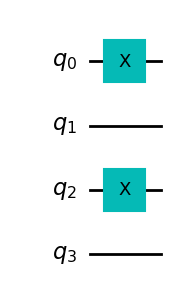

In [11]:
# Prepare a Dihydrogen Molecule within its second_q_op structure:

h2_driver = PySCFDriver(
    atom = "H 0 0 0; H 0 0 0.735",
    basis = "sto3g",
    charge = 0,
    spin = 0,
    unit = DistanceUnit.ANGSTROM,
)

# Create Problem instance for dihydrogen molecule:

diHydro_prob = h2_driver.run()

# Generate the Electronic Hamiltonian for Dihydrogen:

h2_Hamiltonian = diHydro_prob.hamiltonian
coefficients = h2_Hamiltonian.electronic_integrals

# Apply second-quantization transformation to Electronic Hamiltonian:

sq_h2_op = h2_Hamiltonian.second_q_op() # This Second-Quantized Electronic Hamiltonian does NOT contain the nuclei repulsive/attractive terms!

# Set up Jordan-Wigner Mapper/Transformer to bring Second Quantized Hamiltonian into qubit space:

jw_map = JordanWignerMapper()

# Apply mapper to Second Quantized Electronic Hamiltonian:

qubit_h2_Ham = jw_map.map(sq_h2_op)

# Obtain the initial state from which to apply the time evolution of the converted Hamiltonian:

HartreeFock_initial = HartreeFock(diHydro_prob.num_spatial_orbitals, diHydro_prob.num_particles, jw_map,)

# Draw the initial state to evolve:

HartreeFock_initial.draw('mpl')



The cell above produces the initial ground state from which the system will evolve. In the case of the Electronic Hamiltonian, the initial state is called a Hartree-Fock state [17]. Other configurations than the one presented are possible; view the appended reference for further information on Hartree-Fock states.

The cell below controls the general parameters for the qDRIFT algorithm instance to be run. View the comments within the cell to under the purpose of each variable further. All Hamiltonians featured in this notebook have such a cell.

In [2]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

'''These are the general control parameters for the Electronic Hamiltonian. Refer to these (and change) these variables to experiment with various product formulas'''

PF_order = 1 # Order of Product Formula.
final_time = 50 # Termination time of real time evolution.
Trotter_Num = 1 # Trotter number associated with Product Formula construction.
time_step = 0.1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.

evo_time_range = np.arange(0, final_time, time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.


**Run the cell below to execute the selected Product Formula algorithm! Drawing the resulting circuit is optional. Uncomment the command to visualize the circuit.**

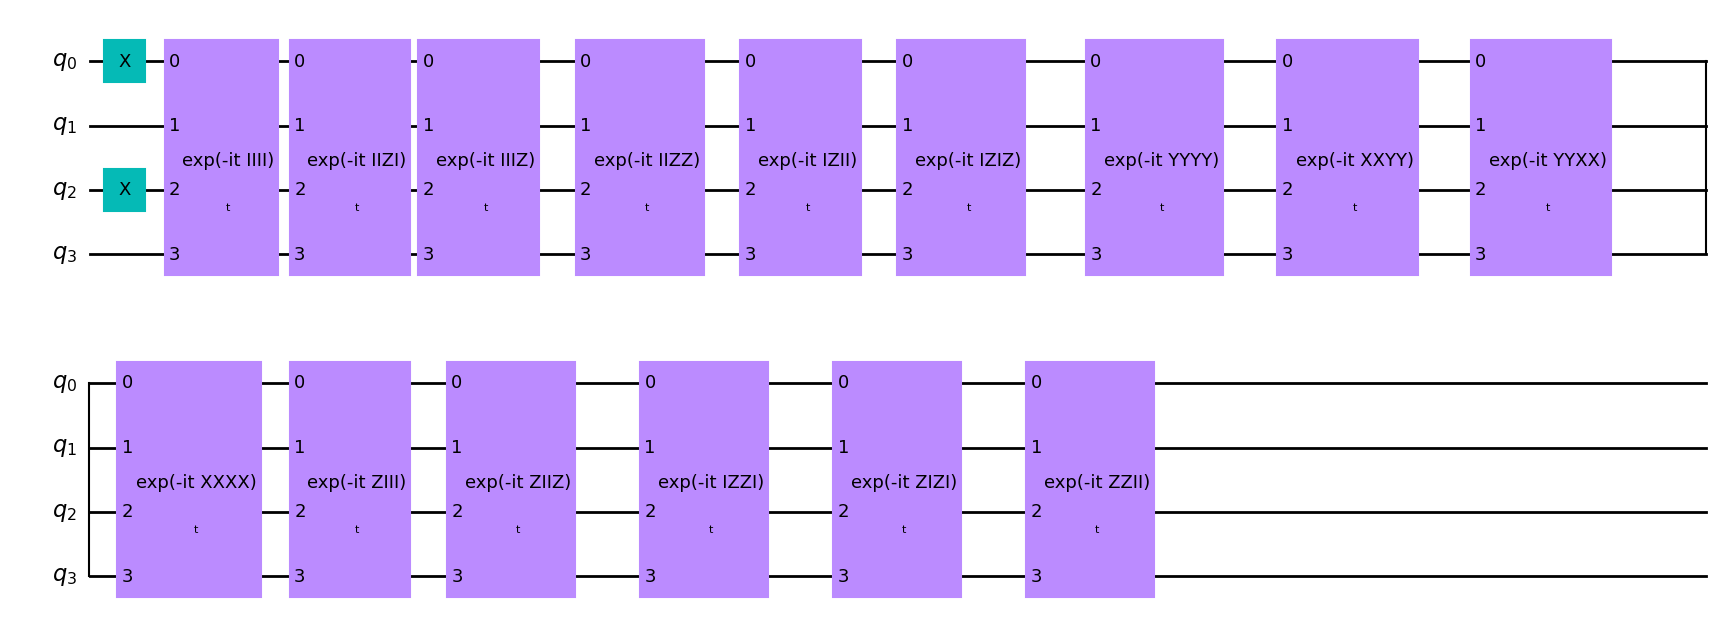

In [13]:
# Obtain the desired Product Formula circuit and draw it:
'''Warning: Circuits grow exponentially in gate complexity (i.e, size) relative to order! Be careful when drawing higher-order circuits!'''

PF_circ = product_formula(qubit_h2_Ham, HartreeFock_initial, PF_order, Trotter_Num, evo_time_range) # Generate the circuit.

PF_circ[0].draw('mpl') # Draw the resulting circuit.

In [35]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

h2_states = identify_states(PF_circ[2], qubit_h2_Ham, evo_time_range)

# Obtain a list of coefficients that correspond to meaningful states: 

h2_coefficients_re_approx = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))
h2_coefficients_im_approx = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))

for i in range(2**qubit_h2_Ham.num_qubits):

    for j in range(len(evo_time_range)):

        real = PF_circ[2][i][j][0]
        imag = PF_circ[2][i][j][1]

        h2_coefficients_re_approx[i][j] = real 
        h2_coefficients_im_approx[i][j] = imag

print("Meaningful states are: " + str(h2_states))

Meaningful states are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


The above list denotes the state numbers (in decimal as opposed to binary) that exhibit some meaningful probablity of being measured when the associated waveform 'collapses.' We we later see that not all of the states featured here are, in ideal circumstances, measurable.

The variable "h2_states" is a 0-indexed list of each of the meaningful states/excitation levels. When attempting to plot the coefficients for each state, change the index (starting from 0) within each instance that "h2_states[any valid index in above list]" appears.

> Example: **h2_coefficients_re_approx[h2_states[2]]** should, if nothing in the above cell has been modified, yield the real and imaginary components of the state coefficient for |0010⟩. 

Try this procedure on all the Hamiltonian types that follow!

#### Electronic Hamiltonian Expectation Value over Time Evolution:

Text(0.5, 1.0, 'Expectation Value of Dihydrogen w/ Order = 1 and Trotter Number = 1')

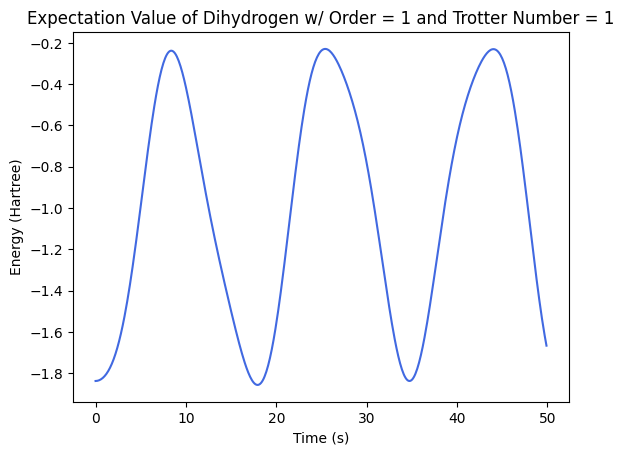

In [16]:
# Graph the energy variation over the specified time interval (in the case of a Suzuki-Trotter circuit):

plt.plot(evo_time_range, PF_circ[1], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen w/ Order = " + str(PF_order) + " and Trotter Number = " + str(Trotter_Num))

The above figure showcases the expectation value of Dihydrogen Hamiltonian within the evolved system. Plots generated will change based upon the Trotter Number, Termination Time, and Product Formula order selected.

#### Electronic Hamiltonian State Coefficients:

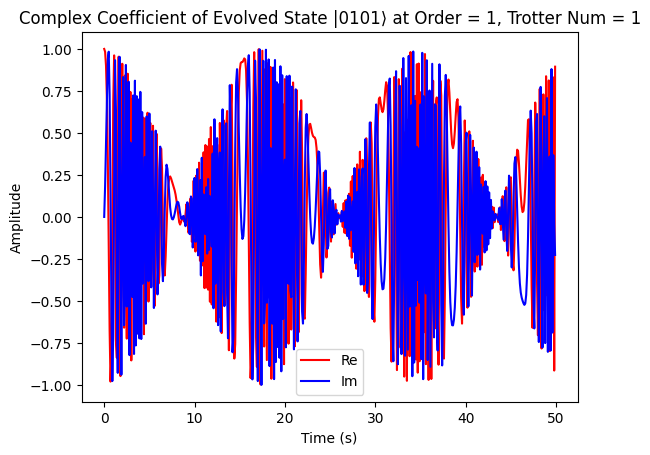

In [17]:
# Plot the evolved state coefficients:

plt.plot(evo_time_range, h2_coefficients_re_approx[h2_states[5]], color = 'r', label = "Re")
plt.plot(evo_time_range, h2_coefficients_im_approx[h2_states[5]], color = 'b', label = "Im")
plt.title('Complex Coefficient of Evolved State |' + format(h2_states[5], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + '⟩ at Order = ' + str(PF_order) + ', Trotter Num = ' + str(Trotter_Num))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")


The above diagram showcases the real and imaginary components of the associated state selected. Try to experiment with different state visualizations by running the cell again after changing the "h2_states" index!

#### Trotter Error Bound:

This widget is employed to calculate the upper Trotter Error bound given the product formula parameters:

In [18]:
# Calculate the expected Trotter Error for Electronic structure Hamiltonian:

alpha_comm_h2 = a_comm(qubit_h2_Ham, PF_order) # Formal defintion found in [20]

h2_error = np.real((alpha_comm_h2 * evo_time_range[-1]**(PF_order + 1)) / Trotter_Num) # Based on [4] commutator-scaled Trotter error using physical Hamiltonians.

print("The expected error term of the Product Formula algorithm, with commutator scaling, is: O(" + str(h2_error) + ")")


The expected error term of the Product Formula algorithm, with commutator scaling, is: O(717.1158653024304)


#### Commutator Pre-Factor:

In [19]:
# Calculate the expected commutator pre-factor given commutator scaling:

print("The associated commutator pre-factor of this product formula is: " + str(np.real(alpha_comm_h2)))

The associated commutator pre-factor of this product formula is: 0.2879971828636954


#### Required Trotter Number:

This widget is employed to calculate the necessary Trotter Number to achieve near-ideal evolution.

In [20]:
# Calculate necessary Trotter_Num to achieve chemical accuracy constant:

trotter_num_need = np.real(((alpha_comm_h2**(1/PF_order) * evo_time_range[-1])**(1+1/PF_order)) / epsilon**(1/PF_order))

print("The required Trotter Number to achieve the desired chemical accuracy is: " + str(int(trotter_num_need)))

The required Trotter Number to achieve the desired chemical accuracy is: 129079


#### Necessary Gate Complexity Bound:

This widget is employed to calculate the gate complexity to ensure constant accuracy:

In [21]:
# Plot the relationship between Product Formula Order and Gate Complexity:

total_gate_complexity = (len(qubit_h2_Ham) * trotter_num_need)

print("The number of gate required to achieve constant accuracy is: O(" + str(int(np.real(total_gate_complexity))) + ").")

The number of gate required to achieve constant accuracy is: O(1936193).


#### Relationship Plots:

The plots within this section will highlight some key characteristics of product formulas. All subsequent Hamiltonians examined within this notebook will feature respective plots dependent on the input parameters for the corresponding Hamiltonian. 

#### Trotter Number vs. Order:

Text(0.5, 1.0, 'Required Trotter Number Relative to Order to Achieve Desired Accuracy')

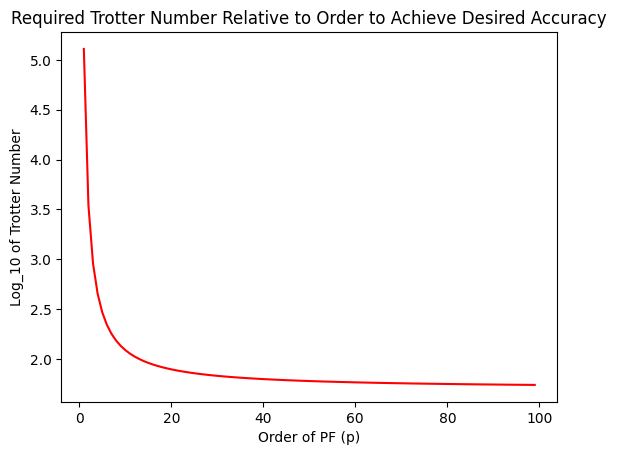

In [22]:
# Plot the relationship between Trotter Number and Product Formula Order:

Order_range = np.arange(1, 100, 1) # Range to plot Product Formula order
Trotter_num_range = list() # List for Trotter Number required per order and qubits.

for j in range(len(Order_range)):
    Trotter_num_range.append(np.log10(np.real(((alpha_comm_h2**(1/Order_range[j]) * evo_time_range[-1])**(1+1/Order_range[j])) / epsilon**(1/Order_range[j]))))

plt.plot(Order_range, Trotter_num_range, color="red")
plt.xlabel("Order of PF (p)")
plt.ylabel("Log_10 of Trotter Number")
plt.title("Required Trotter Number Relative to Order to Achieve Desired Accuracy")

As demonstrated within the above figure, the Trotter Number required to achieve accuracy within an evolution exponentially decreases with higher-order product formulas.

#### Gate Number vs. Order:

Text(0.5, 1.0, 'Required Gate Number Relative to Order to Achieve Desired Accuracy')

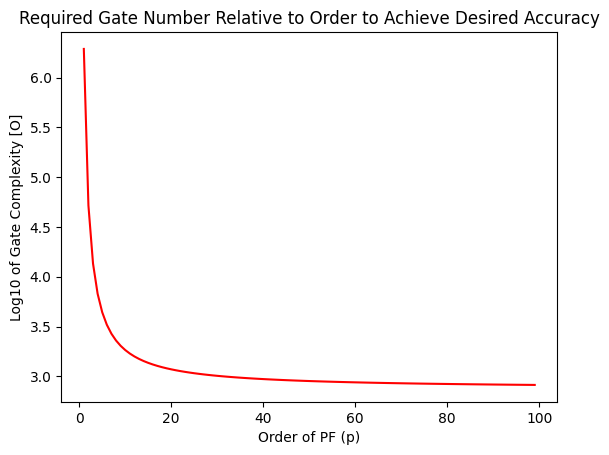

In [23]:
# Plot the relationship between Product Formula Order and Gate Complexity:

gate_compl = list()
Order_range = np.arange(1, 100, 1)

for j in range(len(Order_range)):
    gate_compl.append(len(qubit_h2_Ham) * np.real(((alpha_comm_h2**(1/Order_range[j]) * evo_time_range[-1])**(1+1/Order_range[j])) / epsilon**(1/Order_range[j])))

plt.plot(Order_range, np.log10(gate_compl), color="red")
plt.xlabel("Order of PF (p)")
plt.ylabel("Log10 of Gate Complexity [O]")
plt.title("Required Gate Number Relative to Order to Achieve Desired Accuracy")

#### Trotter Error vs. Time:

Text(0.5, 1.0, 'Calculated Trotter Error Relative to Time, Trot. Num = 1')

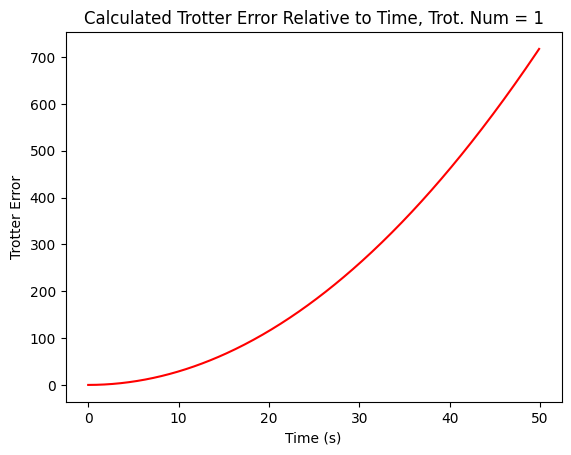

In [24]:
# Plot the relationship between Trotter Error vs. Time (relative to Trotter Number):

error_list = list()

for j in range(len(evo_time_range)):
    error_list.append(np.real((alpha_comm_h2 * evo_time_range[j]**(PF_order + 1)) / Trotter_Num))

plt.plot(evo_time_range, error_list, color="red")
plt.xlabel("Time (s)")
plt.ylabel("Trotter Error")
plt.title("Calculated Trotter Error Relative to Time, Trot. Num = " + str(Trotter_Num))

#### Via Standard Tools:

This section will visualize the ideal time evolution of the respective Hamiltonian and contrast ideal and approximate evolutions of the state coefficients, including the Euclidean distance between each of the sampled coefficient amplitudes from both the ideal and approximate models. Every subsequent Hamiltonian within this notebook is analyzed in this manner.

**The cell below must be executed prior to plotting the comparison between the approximation and ideal time evolutions found below. This must be done for each modification to the approximation model.**

In [36]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

exact_attri = state_generation(qubit_h2_Ham, evo_time_range, HartreeFock_initial)

h2_states = identify_states(exact_attri[0], qubit_h2_Ham, evo_time_range)

# Obtain a list of coefficients that correspond to meaningful states: 

h2_coefficients_re_ex = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))
h2_coefficients_im_ex = np.zeros(shape=(2**(qubit_h2_Ham.num_qubits), len(evo_time_range)))

for i in range(2**qubit_h2_Ham.num_qubits):

    for j in range(len(evo_time_range)):

        real = exact_attri[0][i][j][0]
        imag = exact_attri[0][i][j][1]

        h2_coefficients_re_ex[i][j] = real
        h2_coefficients_im_ex[i][j] = imag

print("Meaningful states are: " + str(h2_states))
        

Meaningful states are: [5, 10]


Just as is presented in the Product Formula-approximate model of this Hamiltonian, the above list denotes the state numbers (in decimal as opposed to binary) that exhibit some meaningful probablity of being measured when the associated waveform "collapses". The number of states that genuinely exhibit non-zero probability ampltitudes may differ from those found in the Product Formula model.

#### Ideal Expectation Value:

/home/ssr/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Expectation Value of Dihydrogen Ham. using Standard Techniques')

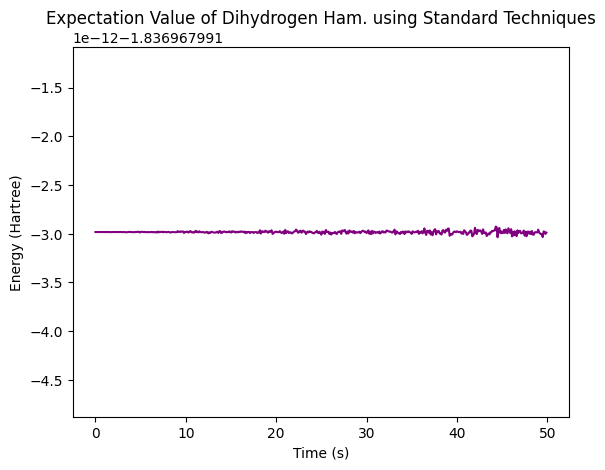

In [26]:
plt.plot(evo_time_range, exact_attri[1], color='purple')
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Dihydrogen Ham. using Standard Techniques")

#### Ideal State Coefficient Evolution:

Text(0.5, 1.0, 'Complex Coefficient of State |0101⟩ using Standard Techniques')

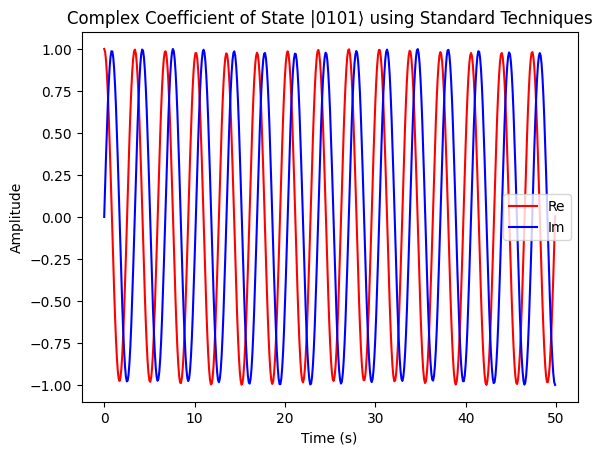

In [27]:
# Plot the Real and Imaginary components of the two resultant states in the evolved statevector:

plt.plot(evo_time_range, h2_coefficients_re_ex[h2_states[0]], color='r', label= "Re")
plt.plot(evo_time_range, h2_coefficients_im_ex[h2_states[0]], color='b', label= "Im")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.title("Complex Coefficient of State |" + format(h2_states[0], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "⟩ using Standard Techniques")

#### Comparision between approximate and ideal evolutions:

We will now compare the two models of time evolution, based upon the chosen product formula configuration, and obtain the Euclidean distance, which denotes the deviation from each ideal state amplitude.

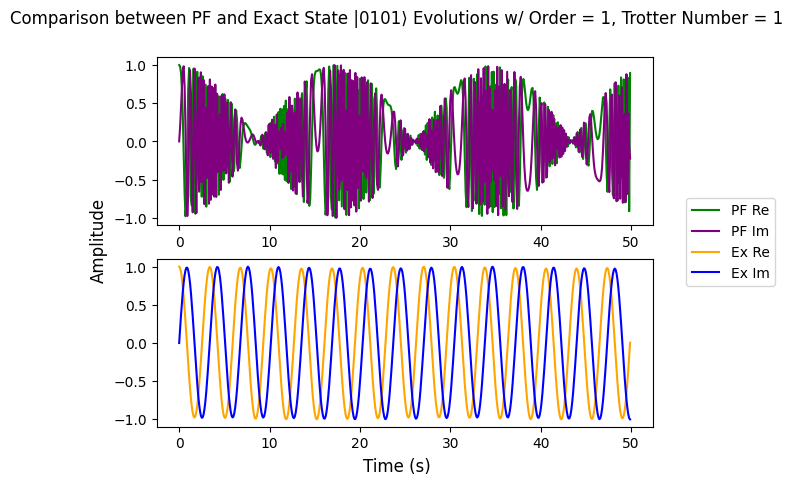

In [28]:
fig, axs = plt.subplots(2)
fig.suptitle("Comparison between PF and Exact State |" + format(h2_states[0], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "⟩ Evolutions w/ Order = " + str(PF_order) + ", Trotter Number = " + str(Trotter_Num))
axs[0].plot(evo_time_range, h2_coefficients_re_approx[h2_states[0]], color = 'g', label = "PF Re")
axs[0].plot(evo_time_range, h2_coefficients_im_approx[h2_states[0]], color = 'purple', label = "PF Im")
axs[1].plot(evo_time_range, h2_coefficients_re_ex[h2_states[0]], color='orange', label= "Ex Re")
axs[1].plot(evo_time_range, h2_coefficients_im_ex[h2_states[0]], color='b', label= "Ex Im")
fig.supxlabel("Time (s)")
fig.supylabel("Amplitude")
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lin, []) for lin in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.865,0.41))

In [232]:
# Calculate the Euclidean Distance between the two state coefficient plots:

for k in range(len(h2_states)):
    h2_re_distance = distance.euclidean(h2_coefficients_re_approx[h2_states[k]], h2_coefficients_re_ex[h2_states[k]])
    h2_im_distance = distance.euclidean(h2_coefficients_im_approx[h2_states[k]], h2_coefficients_im_ex[h2_states[k]])

    print("The Real Euclidean distance/error of state |" + format(h2_states[k], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "⟩ is: " + str(h2_re_distance))
    print("The Imaginary Euclidean distance/error of state |" + format(h2_states[k], '0' + str(qubit_h2_Ham.num_qubits) + 'b') + "⟩ is: " + str(h2_im_distance))

The Real Euclidean distance/error of state |0101⟩ is: 19.32223177531019
The Imaginary Euclidean distance/error of state |0101⟩ is: 18.88220948916317
The Real Euclidean distance/error of state |1010⟩ is: 11.432760899041522
The Imaginary Euclidean distance/error of state |1010⟩ is: 11.911631687663325


This marks the end of analysis regarding the Electronic Hamiltonian. The following Hamiltonians are Lattice-based and comprise two separate system types.

With the exception of some cells, this also marks the end of a guided explanation for all cells present within a Hamiltonian demonstration. Have fun with experimentation!

# Lattice-based Hamiltonians:

**Please run the cell below prior to attempting to execute further cells in this section.**

In [30]:
from math import pi
from qiskit_nature.second_q.hamiltonians.lattices import(
    BoundaryCondition,
    LineLattice,
)
from qiskit_nature.second_q.hamiltonians import HeisenbergModel, IsingModel

## Heisenberg Model (Lattice-based):

The Heisenberg Hamiltonian models the energies of and between nearby spins in various media when said spins are subjected to an arbitrary external magnetic field. The spin-basis form of this Hamiltonian (ferromagnetic) is:

$$ \large \hat{H} = - J \sum_{m}{\hat{S}_m \cdot{\hat{S}_{m+1}}}$$

where ${J}$ is the coupling constant, and ${\hat{S}_m}$  and ${\hat{S}_{m+1}}$ are the spin operators at the lattice site ${m}$ [18].

The Hamiltonian will undergo a logarithmic transformation to obtain a practical qubit space operator. Prior to this, the second quantized form of this Hamiltonian is: 

$$ \large \hat{H} = - J N S^2 + \sum_{k}^{B.Z.}{\omega_k a^{\dagger}_{k} a^{\dagger}_{k} + \mathcal{O} (S^0)}$$

where ${J}$ is the coupling constant, ${N}$ is the total number of lattice sites, ${S}$ is the spin coefficient ${(+1 \ \ or -1)}$, ${B.Z.}$ is the Brillouin Zone bound governing ${N}$, ${ω_k}$ is the dispersion relation of the spin excitations, and ${a_k^{†}}$ and ${a_k}$ are the associated creation and annihilation operators of a spin system [18]. 

However, the Hamiltonian summand grouping scheme employed to obtain the tightest possible bounds using commutator scaling [20] demands that the subsequent qubit space Hamiltonian be grouped in terms of each distinct even-odd Pauli operators:

$$ \large H = \sum_{j=1}^{n-1}{(X_j X_{j+1} + Y_j Y_{j+1} + Z_j Z_{j+1} + h_j Z_j)}$$

$$ \large H_1 = \sum_{j=1}^{n-1}{X_j X_{j+1},} \\[0.1in] H_2 = \sum_{j=1}^{n-1}{Y_j Y_{j+1}, } \\[0.1in] H_3 = \sum_{j=1}^{n-1} (Z_j Z_{j+1} + h_j Z_j)  $$


where ${H_1}$, ${H_2}$, and ${H_3}$ each reflect a grouping of all like operators (e.g., Pauli X operators will be grouped into the ${H_1}$  term) to be exploited in the calculation of the ${\tilde{α}_{comm}}$ term for Trotter Error [20]. This calculation scheme has been done analytically and can simply be viewed at these references: [21, 23]. The following implementation uses only one of these potential terms for the ${\tilde{α}_{comm}}$ coefficient. 


We will now implement simple 1-D Heisenberg Model Hamiltonians using the theory gained thus far.

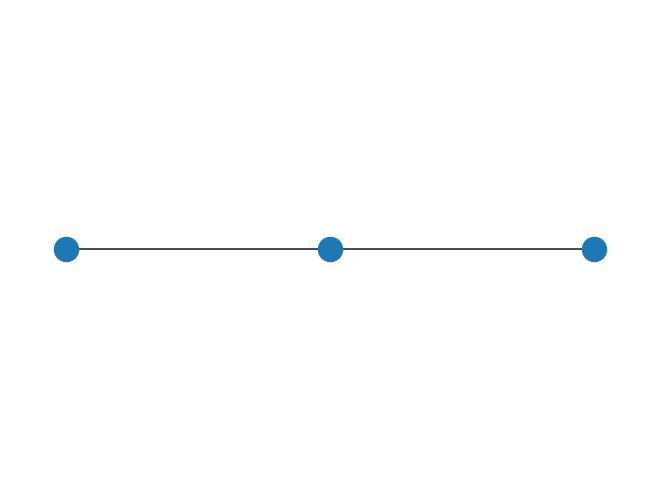

In [31]:
# Instantiate Line_Lattice for Hamiltonian generation:

heisenberg_line_lattice = LineLattice(num_nodes=3, boundary_condition=BoundaryCondition.OPEN)
heisenberg_model = HeisenbergModel(heisenberg_line_lattice, (1.0, 1.0, 1.0), (0.0, 0.0, 1.0))
heisenberg_line_lattice.draw()

In [32]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

'''These are the general control parameters for the Heisenberg Hamiltonian. Refer to these (and change) these variables to experiment with various product formulas'''

hb_PF_order = 1 # Order of Product Formula.
hb_final_time = 50 # Termination time of real time evolution.
hb_Trotter_Num = 1 # Trotter number associated with Product Formula construction.
hb_time_step = 0.1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
hb_epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.

hb_evo_time_range = np.arange(0, hb_final_time, hb_time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.

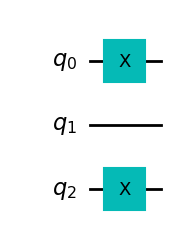

In [33]:
# Obtain Second Quantized operator of Heisenberg Model Hamiltonian:

hb_Ham = heisenberg_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

log_map = LogarithmicMapper()

qubit_hb_Ham = log_map.map(hb_Ham.simplify())

# Construct appropriate ansatz for Time Evolution:

hb_initial_state = QuantumCircuit(qubit_hb_Ham.num_qubits)
hb_initial_state.x(range(0, qubit_hb_Ham.num_qubits, 2))

hb_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian [18].

The cell above produces the initial ground state from which the system will evolve. In the case of the Heisenberg Hamiltonian, the initial state is called the Néel state [18]. Other configurations than the one presented are possible; view the appended reference for further information on Néel states.

**Run the cell below to execute the product formula algorithm! Drawing the resulting circuit is optional. Uncomment the command to visualize the circuit.**

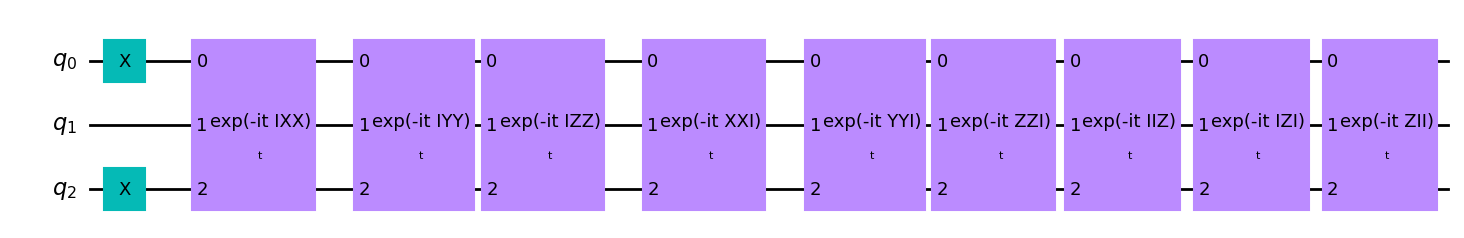

In [34]:
# Construct the product formula for the Heisenberg Hamiltonian given the PF configuration:

hb_PF_circ = product_formula(qubit_hb_Ham, hb_initial_state, hb_PF_order, hb_Trotter_Num, hb_evo_time_range)

hb_PF_circ[0].draw('mpl') # Draw the resulting circuit.

In [45]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

hb_states = identify_states(hb_PF_circ[2], qubit_hb_Ham, hb_evo_time_range) 
'''Be certain to include the output of the product_formula function and not the state_generation function! The former contains the PF values, while the latter contains
    idealized values for the state coefficients!'''

# Obtain a list of coefficients that correspond to meaningful states: 

hb_coefficients_re_approx = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))
hb_coefficients_im_approx = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))

for i in range(2**qubit_hb_Ham.num_qubits):

    for j in range(len(evo_time_range)):

        real = hb_PF_circ[2][i][j][0]
        imag = hb_PF_circ[2][i][j][1]

        hb_coefficients_re_approx[i][j] = real
        hb_coefficients_im_approx[i][j] = imag
        
print("Meaningful states are: " + str(hb_states))

Meaningful states are: [0, 3, 5, 6]


#### Heisenberg Hamiltonian Expectation Value over Time Evolution:

Text(0.5, 1.0, 'Expectation Value of Heisenberg Hamiltonian over Trotterization Evolution')

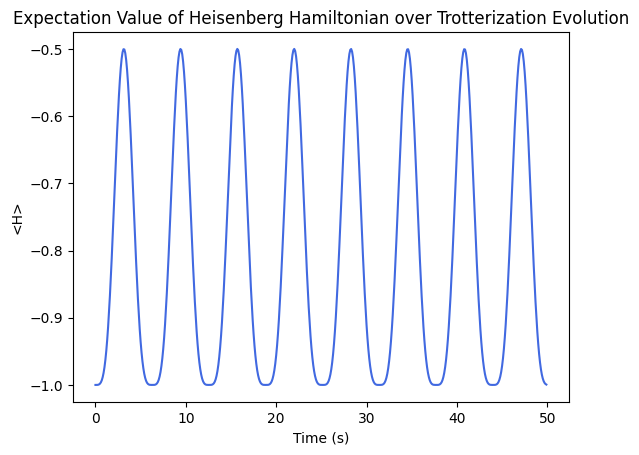

In [46]:
# Graph the energy variation over the specified time interval:

plt.plot(hb_evo_time_range, hb_PF_circ[1], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("<H>")
plt.title("Expectation Value of Heisenberg Hamiltonian over Trotterization Evolution")

#### Heisenberg State Coefficients:

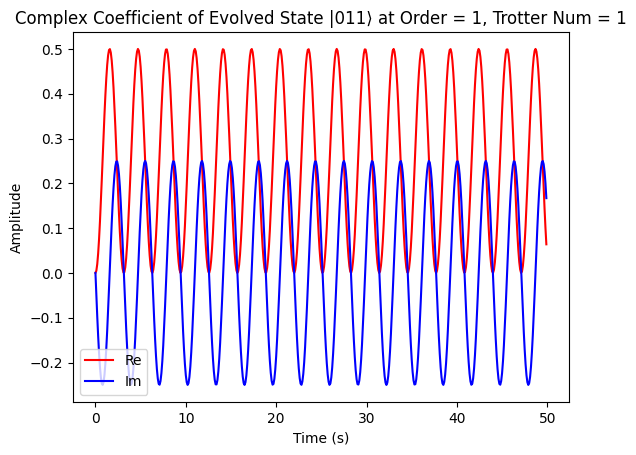

In [62]:
# Plot the evolved state coefficients:

plt.plot(hb_evo_time_range, hb_coefficients_re_approx[hb_states[0]], color = 'r', label = "Re")
plt.plot(hb_evo_time_range, hb_coefficients_im_approx[hb_states[0]], color = 'b', label = "Im")
plt.title('Complex Coefficient of Evolved State |' + format(hb_states[0], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + '⟩ at Order = ' + str(hb_PF_order) + ', Trotter Num = ' + str(hb_Trotter_Num))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")


#### Trotter Error Bound:

In [48]:
# Calculate the expected Trotter Error for the Heisenberg Model Hamiltonian:

hb_a_comm = a_comm(qubit_hb_Ham, hb_PF_order) 

hb_error = np.real((hb_a_comm * hb_evo_time_range[-1]**(hb_PF_order + 1)) / hb_Trotter_Num)

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(hb_error) + ")")

The expected error term of the Lie-Trotter-style algorithm is: O(6847.527500000002)


#### Commutator Pre-factor:

In [49]:
# Calculate the expected commutator pre-factor given commutator scaling:

print("The associated commutator pre-factor of this product formula is: " + str(np.real(hb_a_comm)))

The associated commutator pre-factor of this product formula is: 2.75


#### Trotter Number Required:

In [50]:
# Calculate necessary Trotter_Num to achieve chemical accuracy constant:

hb_trotter_num_need = np.real(((hb_a_comm**(1/hb_PF_order) * hb_evo_time_range[-1])**(1+1/hb_PF_order)) / hb_epsilon**(1/hb_PF_order))

print("The required Trotter Number to achieve the desired chemical accuracy is: " + str(int(hb_trotter_num_need)))

The required Trotter Number to achieve the desired chemical accuracy is: 11769187


#### Necessary Gate Complexity Bound:

In [51]:
# Plot the relationship between Product Formula Order and Gate Complexity:

hb_total_gate_complexity = (len(qubit_hb_Ham) * hb_trotter_num_need)

print("The number of gate required to achieve constant accuracy is: O(" + str(int(np.real(hb_total_gate_complexity))) + ").")

The number of gate required to achieve constant accuracy is: O(105922691).


### Relationship Plots:

#### Trotter Number vs. Order:

Text(0.5, 1.0, 'Required Trotter Number Relative to Order to Achieve Desired Accuracy')

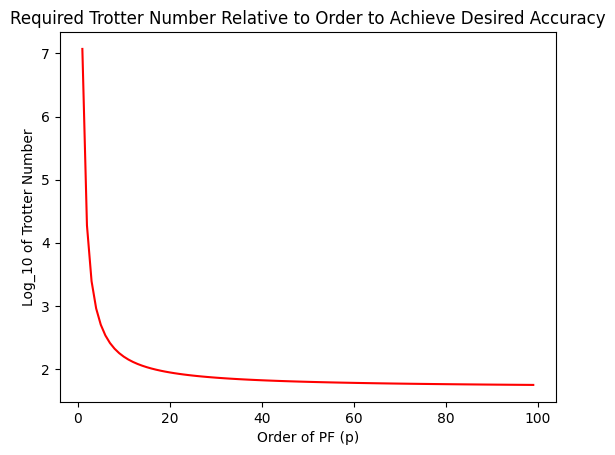

In [52]:
# Plot the relationship between Trotter Number and Product Formula Order:

hb_Order_range = np.arange(1, 100, 1) # Range to plot Product Formula order
hb_Trotter_num_range = list() # List for Trotter Number required per order and qubits.

for j in range(len(hb_Order_range)):
    hb_Trotter_num_range.append(np.log10(np.real(((hb_a_comm**(1/hb_Order_range[j]) * hb_evo_time_range[-1])**(1+1/hb_Order_range[j])) / hb_epsilon**(1/hb_Order_range[j]))))

plt.plot(hb_Order_range, hb_Trotter_num_range, color="red")
plt.xlabel("Order of PF (p)")
plt.ylabel("Log_10 of Trotter Number")
plt.title("Required Trotter Number Relative to Order to Achieve Desired Accuracy")


#### Gate Number vs. Order:

/home/ssr/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Required Gate Number Relative to Order to Achieve Desired Accuracy')

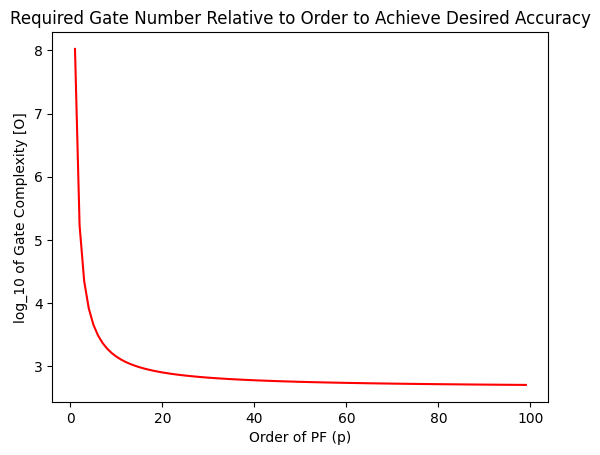

In [53]:
# Plot the relationship between Product Formula Order and Gate Complexity:

hb_gate_compl = list()
hb_Order_range = np.arange(1, 100, 1)

for j in range(len(hb_Order_range)):
    hb_gate_compl.append(len(qubit_hb_Ham) * ((hb_a_comm**(1/hb_Order_range[j]) * hb_evo_time_range[-1])**(1+1/hb_Order_range[j])) / hb_epsilon**(1/hb_Order_range[j]))

plt.plot(hb_Order_range, np.log10(hb_gate_compl), color="red")
plt.xlabel("Order of PF (p)")
plt.ylabel("log_10 of Gate Complexity [O]")
plt.title("Required Gate Number Relative to Order to Achieve Desired Accuracy")

#### Trotter Error vs. Time:

Text(0.5, 1.0, 'Calculated Trotter Error Relative to Time, Trot. Num = 1, Nodes = 3')

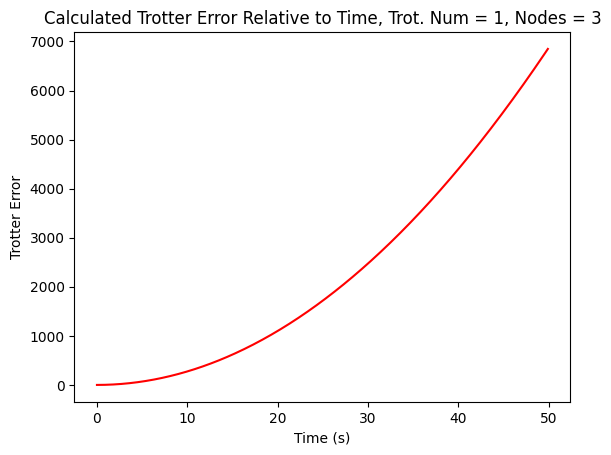

In [54]:
# Plot the relationship between Trotter Error vs. Time (relative to Trotter Number):

error_list = list()

for j in range(len(hb_evo_time_range)):
    error_list.append(np.real((hb_a_comm * hb_evo_time_range[j]**(hb_PF_order + 1)) / hb_Trotter_Num))

plt.plot(hb_evo_time_range, error_list, color="red")
plt.xlabel("Time (s)")
plt.ylabel("Trotter Error")
plt.title("Calculated Trotter Error Relative to Time, Trot. Num = " + str(hb_Trotter_Num) + ", Nodes = " + str(heisenberg_line_lattice.num_nodes))

#### Via Standard Techniques: 

**The cell below must be executed prior to plotting the comparison between the approximation and ideal time evolutions found below. This must be done for each modification to the approximation model.**

In [55]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

exact_attri = state_generation(qubit_hb_Ham, hb_evo_time_range, hb_initial_state)

hb_states = identify_states(exact_attri[0], qubit_hb_Ham, hb_evo_time_range)

# Obtain a list of coefficients that correspond to meaningful states: 

hb_coefficients_re_ex = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))
hb_coefficients_im_ex = np.zeros(shape=(2**(qubit_hb_Ham.num_qubits), len(hb_evo_time_range)))

for i in range(2**qubit_hb_Ham.num_qubits):

    for j in range(len(evo_time_range)):

        real = exact_attri[0][i][j][0]
        imag = exact_attri[0][i][j][1]

        hb_coefficients_re_ex[i][j] = real
        hb_coefficients_im_ex[i][j] = imag
    
print("Meaningful states are: " + str(hb_states))
        

Meaningful states are: [3, 5, 6]


#### Ideal Expectation Value:

/home/ssr/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0.5, 1.0, 'Expectation Value of Heisenberg Ham. using Standard Techniques')

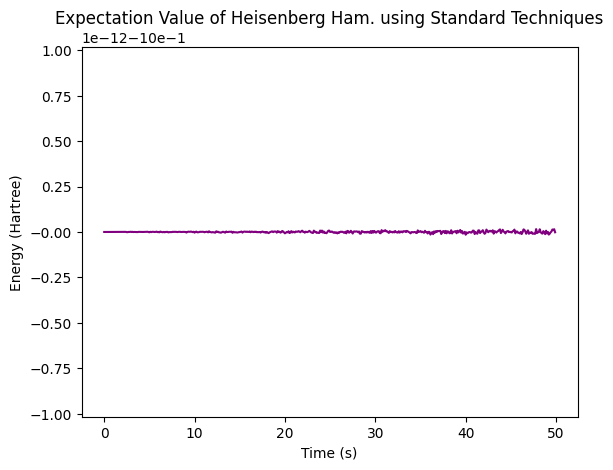

In [56]:
# Plot the expectation value of the exact time evolution:

plt.plot(hb_evo_time_range, exact_attri[1], color='purple')
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Heisenberg Ham. using Standard Techniques")

#### Ideal State Coefficient Evolution:

Text(0.5, 1.0, 'Complex Coefficient of State |011⟩ using Standard Techniques')

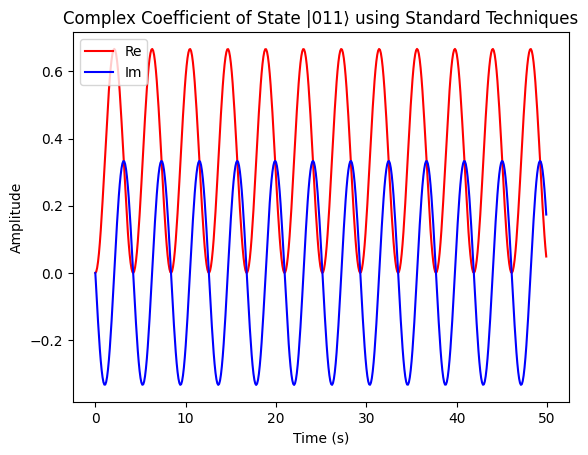

In [57]:
# Plot the Real and Imaginary components of the two resultant states in the evolved statevector:

plt.plot(hb_evo_time_range, hb_coefficients_re_ex[hb_states[0]], color='r', label= "Re")
plt.plot(hb_evo_time_range, hb_coefficients_im_ex[hb_states[0]], color='b', label= "Im")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.title("Complex Coefficient of State |" + format(hb_states[0], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "⟩ using Standard Techniques")

#### Comparison between Approximate and Ideal Evolutions:

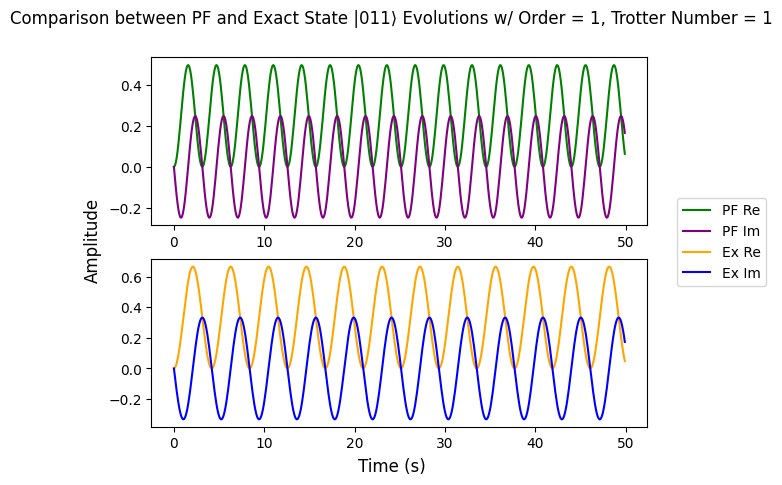

In [63]:
fig, axs = plt.subplots(2)
fig.suptitle("Comparison between PF and Exact State |" + format(hb_states[0], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "⟩ Evolutions w/ Order = " + str(hb_PF_order) + ", Trotter Number = " + str(hb_Trotter_Num))
axs[0].plot(evo_time_range, hb_coefficients_re_approx[hb_states[0]], color = 'g', label = "PF Re")
axs[0].plot(evo_time_range, hb_coefficients_im_approx[hb_states[0]], color = 'purple', label = "PF Im")
axs[1].plot(evo_time_range, hb_coefficients_re_ex[hb_states[0]], color='orange', label= "Ex Re")
axs[1].plot(evo_time_range, hb_coefficients_im_ex[hb_states[0]], color='b', label= "Ex Im")
fig.supxlabel("Time (s)")
fig.supylabel("Amplitude")
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lin, []) for lin in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.865,0.41))

In [92]:
# Calculate the Euclidean Distance between the two state coefficient plots:

for k in range(len(hb_states)):
    heisenberg_re_distance = distance.euclidean(hb_coefficients_re_approx[hb_states[k]], hb_coefficients_re_ex[hb_states[k]])
    heisenberg_im_distance = distance.euclidean(hb_coefficients_im_approx[hb_states[k]], hb_coefficients_im_ex[hb_states[k]])

    print("The Real Euclidean distance/error of state |" + format(hb_states[k], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "⟩ is: " + str(heisenberg_re_distance))
    print("The Imaginary Euclidean distance/error of state |" + format(hb_states[k], '0' + str(qubit_hb_Ham.num_qubits) + 'b') + "⟩ is: " + str(heisenberg_im_distance))

The Real Euclidean distance/error of state |011⟩ is: 6.86467834427163
The Imaginary Euclidean distance/error of state |011⟩ is: 6.605544924126091
The Real Euclidean distance/error of state |101⟩ is: 13.918748037015236
The Imaginary Euclidean distance/error of state |101⟩ is: 13.792783906158453
The Real Euclidean distance/error of state |110⟩ is: 10.233262919852665
The Imaginary Euclidean distance/error of state |110⟩ is: 9.526652988807701


## Ising Model (Lattice-based):

The Transverse-field Ising Hamiltonian, like the Heisenberg Hamiltonian, represents a ferromagnetic lattice system that is occupied by spin ½ particles that experience interactions between nearest-neighbors and external magnetic fields:

$$ \large H = - \sum_{\langle i, j \rangle}{J_{ij} Z_i Z_j} \ - \sum_{i}{g_i X_i}$$

This model features interactions between lattice sites at the ${i}$-th and ${j}$-th locations, and the external magnetic field acts on the ${i}$-th site. The variable ${J_{ij}}$ is the coupling constant between ${i}$-th and ${j}$-th site, while the coupling parameters ${g_i}$ determine the relative strength between the nearest neighbor interactions and external transverse field [21].

The second quantized form of the Hamiltonian is akin to the Heisenberg Hamiltonian equivalent; likewise, the following implementation also employs the logarithmic transformation/mapper to bring the bosonic system to the qubit space. 

We will now implement first- and higher-order product formulas using Ising Hamiltonians and compare results to the ideal time evolution.

In [66]:
# Instantiate Line_Lattice for Hamiltonian generation:

ising_line_lattice = LineLattice(num_nodes=4, boundary_condition=BoundaryCondition.OPEN)
ising_model = IsingModel(
    ising_line_lattice.uniform_parameters(
        uniform_interaction = -1.0,
        uniform_onsite_potential = 1.0,
    ),
)

In [67]:
# Select an appropriate order, accuracy, evolution time, time step size, and Trotter number for the Product Formula:

'''These are the general control parameters for the Electronic Hamiltonian. Refer to these (and change) these variables to experiment with various product formulas'''

i_PF_order = 1 # Order of Product Formula.
i_final_time = 50 # Termination time of real time evolution.
i_Trotter_Num = 1 # Trotter number associated with Product Formula construction.
i_time_step = 0.1 # Time step increment for sampling purposes. Does not affect the Product Formula construction.
i_epsilon = 1.6 * 10**-3 # Select a desired chemical accuracy for simulation purposes.

i_evo_time_range = np.arange(0, i_final_time, i_time_step) # Define a time evolution range that will scale to the plotted Hamiltonian evolution.

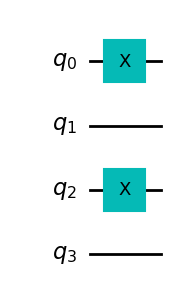

In [71]:
# Obtain Second Quantized operator of Ising Model Hamiltonian:

i_Ham = ising_model.second_q_op()

# Invoke Linear Mapper/Transformation to bring Hamiltonian into Qubit Space:

log_map = LogarithmicMapper()

qubit_i_Ham = log_map.map(i_Ham.simplify())

# Construct appropriate ansatz for Real Time Evolution:

i_initial_state = QuantumCircuit(qubit_i_Ham.num_qubits)
i_initial_state.x(range(0, qubit_i_Ham.num_qubits, 2))

i_initial_state.draw('mpl') # Known as the Néel state of a Lattice-based Hamiltonian

**Run the cell below to execute the product formula algorithm! Drawing the resulting circuit is optional. Uncomment the command to visualize the circuit.**

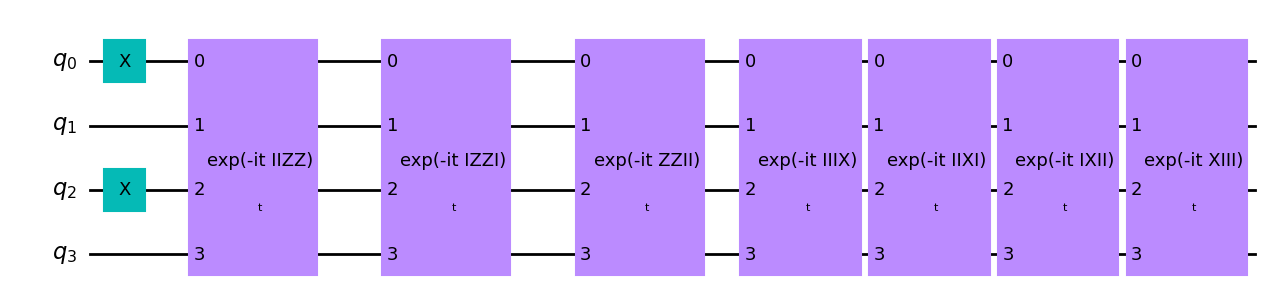

In [72]:
# Construct the product formula for the Heisenberg Hamiltonian given the PF configuration:

i_PF_circ = product_formula(qubit_i_Ham, i_initial_state, i_PF_order, i_Trotter_Num, i_evo_time_range)

i_PF_circ[0].draw('mpl') # Draw the resulting circuit.

In [73]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

i_states = identify_states(i_PF_circ[2], qubit_i_Ham, i_evo_time_range) 
'''Be certain to include the output of the product_formula function and not the state_generation function! The former contains the PF values, while the latter contains
    idealized values for the state coefficients!'''

# Obtain a list of coefficients that correspond to meaningful states: 

i_coefficients_re_approx = np.zeros(shape=(2**(qubit_i_Ham.num_qubits), len(i_evo_time_range)))
i_coefficients_im_approx = np.zeros(shape=(2**(qubit_i_Ham.num_qubits), len(i_evo_time_range)))

for i in range(2**qubit_i_Ham.num_qubits):

    for j in range(len(i_evo_time_range)):

        real = i_PF_circ[2][i][j][0]
        imag = i_PF_circ[2][i][j][1]

        i_coefficients_re_approx[i][j] = real
        i_coefficients_im_approx[i][j] = imag
        
print("Meaningful states are: " + str(i_states))

Meaningful states are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


#### Ising Hamiltonian Expectation Value over Time Evolution:

Text(0.5, 1.0, 'Expectation Value of Ising Hamiltonian over Trotterization Evolution')

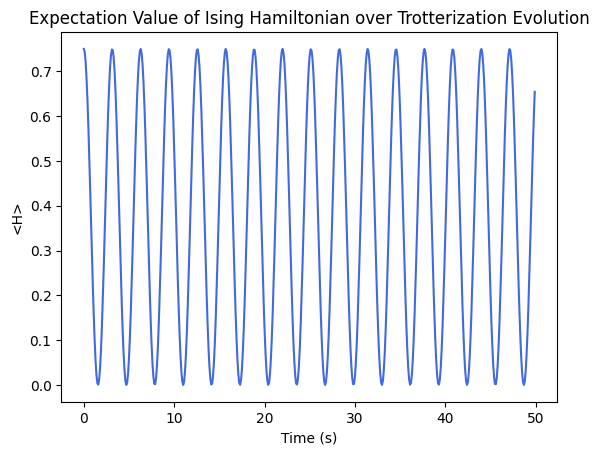

In [74]:
# Graph the energy variation over the specified time interval:

plt.plot(i_evo_time_range, i_PF_circ[1], color="royalblue")
plt.xlabel("Time (s)")
plt.ylabel("<H>")
plt.title("Expectation Value of Ising Hamiltonian over Trotterization Evolution")

#### Ising State Coefficients:

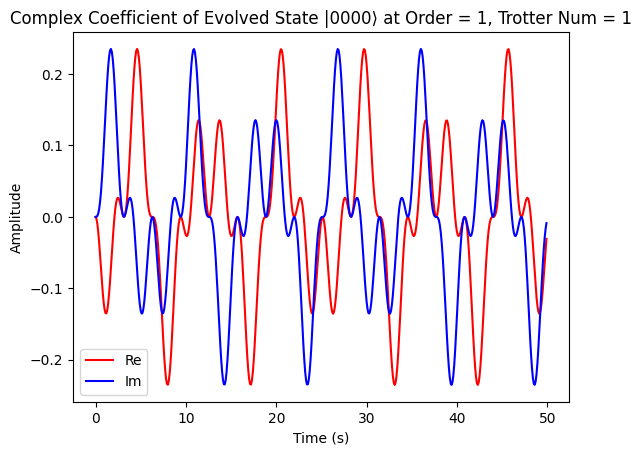

In [75]:
# Plot the evolved state coefficients:

plt.plot(i_evo_time_range, i_coefficients_re_approx[i_states[0]], color = 'r', label = "Re")
plt.plot(i_evo_time_range, i_coefficients_im_approx[i_states[0]], color = 'b', label = "Im")
plt.title('Complex Coefficient of Evolved State |' + format(i_states[0], '0' + str(qubit_i_Ham.num_qubits) + 'b') + '⟩ at Order = ' + str(i_PF_order) + ', Trotter Num = ' + str(i_Trotter_Num))
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")


#### Trotter Error Bound:

In [76]:
# Calculate the expected Trotter Error for the Heisenberg Model Hamiltonian:

i_a_comm = a_comm(qubit_i_Ham, i_PF_order) 

i_error = np.real(i_a_comm * i_evo_time_range[-1]**(i_PF_order + 1) / i_Trotter_Num)

print("The expected error term of the Lie-Trotter-style algorithm is: O(" + str(i_error) + ")")

The expected error term of the Lie-Trotter-style algorithm is: O(3735.0150000000012)


#### Commutator Pre-factor:

In [78]:
# Calculate the expected commutator pre-factor given commutator scaling:

print("The associated commutator pre-factor of this product formula is: " + str(alpha_comm_h2))

The associated commutator pre-factor of this product formula is: (0.2879971828636954+0j)


#### Trotter Number Required:

In [79]:
# Calculate necessary Trotter_Num to achieve chemical accuracy constant:

i_trotter_num_need = np.real(((i_a_comm**(1/i_PF_order) * i_evo_time_range[-1])**(1+1/i_PF_order)) / i_epsilon**(1/i_PF_order))

print("The required Trotter Number to achieve the desired chemical accuracy is: " + str(int(i_trotter_num_need)))

The required Trotter Number to achieve the desired chemical accuracy is: 3501576


#### Necessary Gate Complexity Bound:

In [80]:
# Plot the relationship between Product Formula Order and Gate Complexity:

i_total_gate_complexity = (len(qubit_i_Ham) * i_trotter_num_need)

print("The number of gate required to achieve constant accuracy is: O(" + str(int(np.real(i_total_gate_complexity))) + ").")

The number of gate required to achieve constant accuracy is: O(24511035).


### Relationship Plots:

#### Trotter Number vs. Order:

Text(0.5, 1.0, 'Required Trotter Number Relative to Order to Achieve Desired Accuracy')

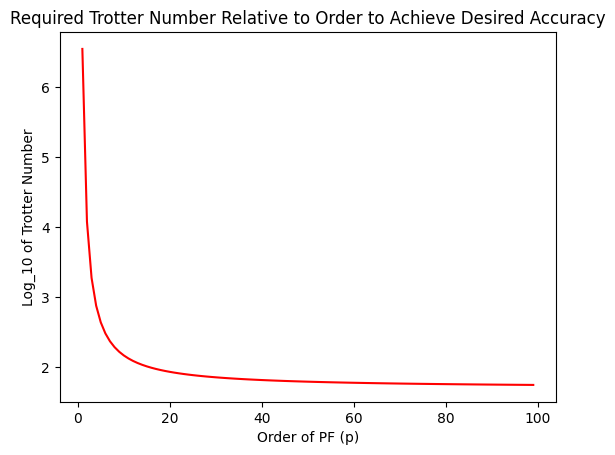

In [85]:
# Plot the relationship between Trotter Number and Product Formula Order:

i_Order_range = np.arange(1, 100, 1) # Range to plot Product Formula order
i_Trotter_num_range = list() # List for Trotter Number required per order and qubits.

for j in range(len(i_Order_range)):
    i_Trotter_num_range.append(np.log10(np.real(((i_a_comm**(1/i_Order_range[j]) * i_evo_time_range[-1])**(1+1/i_Order_range[j])) / i_epsilon**(1/i_Order_range[j]))))

plt.plot(i_Order_range, i_Trotter_num_range, color="red")
plt.xlabel("Order of PF (p)")
plt.ylabel("Log_10 of Trotter Number")
plt.title("Required Trotter Number Relative to Order to Achieve Desired Accuracy")

#### Gate Number vs. Order:

Text(0.5, 1.0, 'Required Gate Number Relative to Order to Achieve Desired Accuracy')

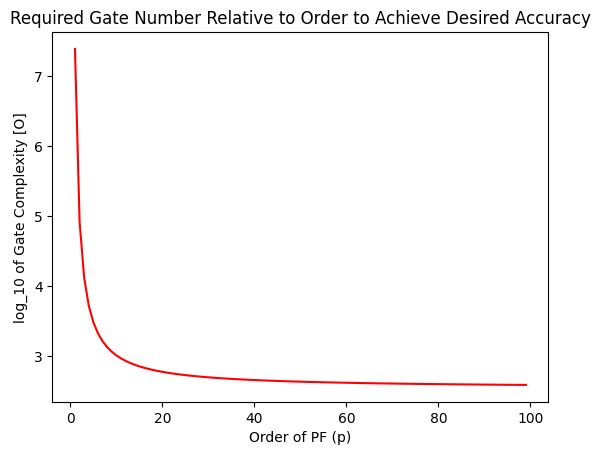

In [84]:
# Plot the relationship between Product Formula Order and Gate Complexity:

i_gate_compl = list()
i_Order_range = np.arange(1, 100, 1)

for j in range(len(i_Order_range)):
    i_gate_compl.append(len(qubit_i_Ham) * np.real(((i_a_comm**(1/i_Order_range[j]) * i_evo_time_range[-1])**(1+1/i_Order_range[j])) / i_epsilon**(1/i_Order_range[j])))

plt.plot(i_Order_range, np.log10(i_gate_compl), color="red")
plt.xlabel("Order of PF (p)")
plt.ylabel("log_10 of Gate Complexity [O]")
plt.title("Required Gate Number Relative to Order to Achieve Desired Accuracy")

#### Trotter Error vs. Time: 

Text(0.5, 1.0, 'Calculated Trotter Error Relative to Time, Trot. Num = 1, Nodes = 4')

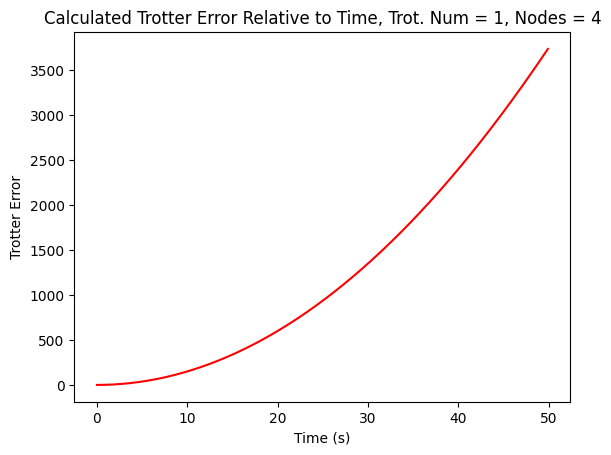

In [83]:
# Plot the relationship between Trotter Error vs. Time (relative to Trotter Number):

error_list = list()

for j in range(len(i_evo_time_range)):
    error_list.append(np.real((i_a_comm * i_evo_time_range[j]**(i_PF_order + 1)) / i_Trotter_Num))

plt.plot(i_evo_time_range, error_list, color="red")
plt.xlabel("Time (s)")
plt.ylabel("Trotter Error")
plt.title("Calculated Trotter Error Relative to Time, Trot. Num = " + str(i_Trotter_Num) + ", Nodes = " + str(ising_line_lattice.num_nodes))

#### Via Standard Techniques:

**The cell below must be executed prior to plotting the comparison between the approximation and ideal time evolutions found below. This must be done for each modification to the approximation model.**

In [86]:
# Obtain a list of states that are meaningful to plot (i.e., have some probability of being measured):

exact_attri = state_generation(qubit_i_Ham, i_evo_time_range, i_initial_state)

i_states = identify_states(exact_attri[0], qubit_i_Ham, i_evo_time_range)

# Obtain a list of coefficients that correspond to meaningful states: 

i_coefficients_re_ex = np.zeros(shape=(2**(qubit_i_Ham.num_qubits), len(i_evo_time_range)))
i_coefficients_im_ex = np.zeros(shape=(2**(qubit_i_Ham.num_qubits), len(i_evo_time_range)))

for i in range(2**qubit_i_Ham.num_qubits):

    for j in range(len(i_evo_time_range)):

        real = exact_attri[0][i][j][0]
        imag = exact_attri[0][i][j][1]

        i_coefficients_re_ex[i][j] = real
        i_coefficients_im_ex[i][j] = imag

print("Meaningful states are: " + str(i_states))
        

Meaningful states are: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


#### Ideal Expectation Value:

Text(0.5, 1.0, 'Expectation Value of Ising Ham. using Standard Techniques')

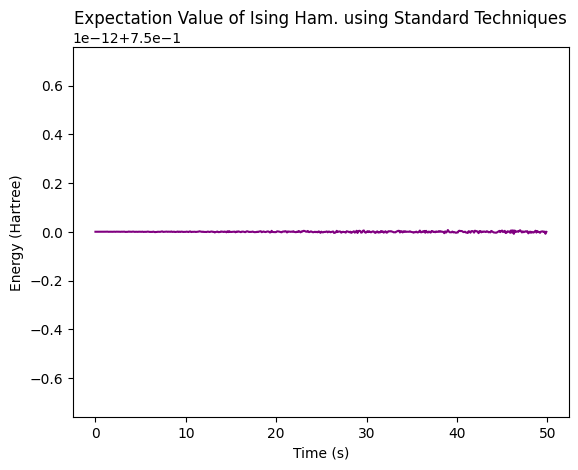

In [88]:
# Plot the expectation value of the exact time evolution:

plt.plot(i_evo_time_range, exact_attri[1], color='purple')
plt.xlabel("Time (s)")
plt.ylabel("Energy (Hartree)")
plt.title("Expectation Value of Ising Ham. using Standard Techniques")

#### Ideal State Coefficient Evolution:

Text(0.5, 1.0, 'Complex Coefficients of State |0000⟩ using Standard Techniques')

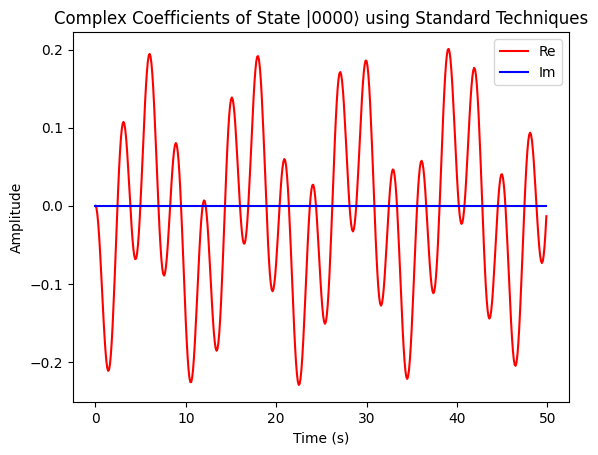

In [89]:
# Plot the Real and Imaginary components of the two resultant states in the evolved statevector:

plt.plot(i_evo_time_range, i_coefficients_re_ex[i_states[0]], color='r', label= "Re")
plt.plot(i_evo_time_range, i_coefficients_im_ex[i_states[0]], color='b', label= "Im")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend(loc="best")
plt.title("Complex Coefficients of State |" + format(i_states[0], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "⟩ using Standard Techniques")

#### Comparison between Approximate and Ideal Evolutions:

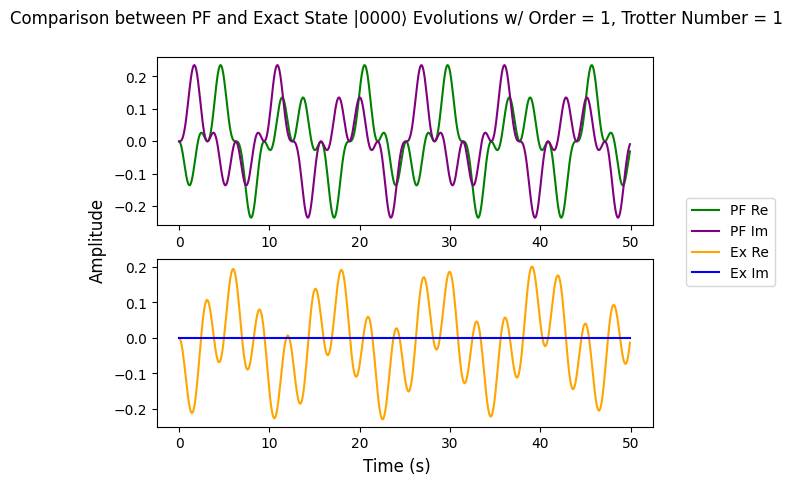

In [90]:
fig, axs = plt.subplots(2)
fig.suptitle("Comparison between PF and Exact State |" + format(i_states[0], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "⟩ Evolutions w/ Order = " + str(i_PF_order) + ", Trotter Number = " + str(i_Trotter_Num))
axs[0].plot(i_evo_time_range, i_coefficients_re_approx[i_states[0]], color = 'g', label = "PF Re")
axs[0].plot(i_evo_time_range, i_coefficients_im_approx[i_states[0]], color = 'purple', label = "PF Im")
axs[1].plot(i_evo_time_range, i_coefficients_re_ex[i_states[0]], color='orange', label= "Ex Re")
axs[1].plot(i_evo_time_range, i_coefficients_im_ex[i_states[0]], color='b', label= "Ex Im")
fig.supxlabel("Time (s)")
fig.supylabel("Amplitude")
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lin, []) for lin in zip(*lines_labels)]
fig.legend(lines, labels, loc=(0.865,0.41))

In [91]:
# Calculate the Euclidean Distance between the two state coefficient plots:

for k in range(len(i_states)):
    ising_re_distance = distance.euclidean(i_coefficients_re_approx[i_states[k]], i_coefficients_re_ex[i_states[k]])
    ising_im_distance = distance.euclidean(i_coefficients_im_approx[i_states[k]], i_coefficients_im_ex[i_states[k]])

    print("The Real Euclidean distance/error of state |" + format(i_states[k], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "⟩ is: " + str(ising_re_distance))
    print("The Imaginary Euclidean distance/error of state |" + format(i_states[k], '0' + str(qubit_i_Ham.num_qubits) + 'b') + "⟩ is: " + str(ising_im_distance))

The Real Euclidean distance/error of state |0000⟩ is: 3.4670096623446254
The Imaginary Euclidean distance/error of state |0000⟩ is: 2.4270298575349645
The Real Euclidean distance/error of state |0001⟩ is: 3.6413422950934806
The Imaginary Euclidean distance/error of state |0001⟩ is: 4.46651272668472
The Real Euclidean distance/error of state |0010⟩ is: 4.474688737362858
The Imaginary Euclidean distance/error of state |0010⟩ is: 4.933854253112212
The Real Euclidean distance/error of state |0011⟩ is: 3.938281531412705
The Imaginary Euclidean distance/error of state |0011⟩ is: 3.5549758268517957
The Real Euclidean distance/error of state |0100⟩ is: 4.292393473696672
The Imaginary Euclidean distance/error of state |0100⟩ is: 4.98200377505475
The Real Euclidean distance/error of state |0101⟩ is: 11.654082038506017
The Imaginary Euclidean distance/error of state |0101⟩ is: 11.119782560436791
The Real Euclidean distance/error of state |0110⟩ is: 4.6168110652367345
The Imaginary Euclidean dista

With all Hamiltonians accounted, we will provide a summary of product formulas, their pros and cons, and a review of their performance.

## Discussion



As demonstrated within the attribute widgets present within each Hamiltonian section (e.g., “Trotter Error Bound”), Lie-Suzuki-Trotter product formulas can approximate a given system for large intervals of time when similarly large repetitions (i.e., Trotter number) of a product formula are configured. In terms of broad functionality, product formulas are an alternative to simulating complex Hamiltonians by partitioning summands into discrete unitary operators, but the viability of this approach decreases as simulation time increases. This diminished viability is due to the exponentially increasing gate complexity relative to the necessary Trotter number for accurate simulation [1]. Likewise, the order of the product formula selected directly contributes to the upper Trotter error bound within the constructed circuit. Error mitigation techniques can be employed to lower this upper bound at the cost of introducing further gates within the circuit: ancillary qubits may be employed as well, but their employment would undermine one of the primary motivations behind the usage of product formulas for simulation [1]. 

Nevertheless, usage and viability of product formulas will grow upon the advent of fault-tolerant quantum computation. Recently developed alternatives to product formulas, such as multi-product formulas, qDRIFT, qubitization, and variational methods, exist and have seen widespread adoption over the algorithm examined in this notebook [23]. However, the exploitation of Hamiltonian commutativity has generated renewed relevance in practical product formula-based quantum dynamics simulation, lowering the upper bound of Trotter error [1]. Despite this, further developments in quantum simulation will yield greater improvements in accuracy and gate complexity. 

In summary, the associated pros and cons of product formulas are: 

- Pros:
    - Product formulas do not employ ancilla qubits to perform simulations [1].
    - Exploitation of Hamiltonian commutativity has produced Trotter error bounds lower than current expected bounds for other algorithms [8].
- Cons:
    - Exponentially increasing gate complexity and Trotter error relative to product formula order [1].
    - Accuracy necessitates large Trotter numbers and product formula order [1].

## Citations

1.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 4.
2.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 12.
3.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 13.
4.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 22.
5.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 24.
6.	Wiebe, N., Dominic, B., Høyer, P., Sanders, B. C. Higher Order Decompositions of Ordered Operator Exponentials. J. Phys. A: Math. Theor. 43, 065203 (2010), 3.
7.	Qiskit – VarQRTE Documentation: https://qiskit.org/documentation/stubs/qiskit.algorithms.VarQRTE.html 
8.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 4-6.
9.	Childs, A. M., Maslov, D., Nam, Y., Ross, N. J., Su, Y. Toward the first quantum simulation with quantum speedup. Proceedings of the National Academy of Sciences 115, 9456-9461 (2018).
10.	Masuo Suzuki, General theory of fractal path integrals with applications to many-body theories and statistical physics, Journal of Mathematical Physics 32 (1991), no. 2, 400–407.
11.	Seth Lloyd, Universal quantum simulators, Science 273 (1996), no. 5278, 1073–1078
12.	Low, G. H. & Chuang, I. L. Hamiltonian simulation by qubitization. Quantum 3, 163 (2019).
13.	Berry, D. W., Gidney, C., Motta, M. McClean, J. R. & Babbush, R. Qubitization of arbitrary basis quantum chemistry leveraging sparsity and low rank factorization. Quantum 3, 208 (2019).
14.	Childs, A. M. Universal computation by quantum walk. Phys. Rev. Lett. 102, 180501 (2009).
15.	Childs, A. M. On the relationship between continuous- and discrete-time quantum walk. Commun. Math. Phys. 294, 581-603 (2009).
16.	Berry, D. W. & Childs, A. M. Black-box Hamiltonian simulation and unitary implementation. Quantum Inf. Comput. 12, 29-62 (2012). 
17.	Qiskit – Electronic Structure: https://qiskit.org/ecosystem/nature/tutorials/01_electronic_structure.html
18.	Quantum Condensed Matter Field Theory (Chapter 2) - University of Cambridge Lecture Notes: https://www.tcm.phy.cam.ac.uk/~bds10/tp3/secqu.pdf 
19.	Born-Oppenheimer Approximation – Northeastern University Lecture Notes: https://web.northeastern.edu/afeiguin/phys5870/phys5870/node9.html 
20.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 40.
21.	Qiskit – Transverse-field Ising Models: https://qiskit.org/ecosystem/nature/stubs/qiskit_nature.second_q.hamiltonians.IsingModel.html 
22.	Childs, A. M., Su, Y., Tran, M. C., Wiebe, N., Zhu, S. A Theory of Trotter Error. Phys. Rev. X. 11, 011020 (2021). 74-75.
23. Miessen, A., Ollitrault, P.J., Tacchino, F. et al. Quantum algorithms for quantum dynamics. Nat Comput Sci 3, 25–37 (2023). 
24. Su, Yuan. *A Theory of Trotter Error* [Video]. Youtube. (2020). https://www.youtube.com/watch?v=3AVnKJ3uCrU
25. Low, G. H., Su, Y., Tong, Y., Tran, M. C., On the complexity of implementing Trotter steps. PRX Quantum 4, 020323 (2023). 
